In [5]:
#packages needed for the tutorial
#using BPTT
using Flux
using Random
using Distributions
using Plots
using Deconvolution
using Wavelets
using NPZ

ERROR: LoadError: IOError: could not spawn setenv(`lld.exe -flavor gnu -m i386pep -Bdynamic --enable-auto-image-base --allow-multiple-definition --disable-auto-import --disable-runtime-pseudo-reloc '' -shared -o 'C:\Users\alena.braendle\.julia\compiled\v1.10\Statistics\jl_A1A3.tmp' --whole-archive 'C:\Users\alena.braendle\.julia\compiled\v1.10\Statistics\jl_A1A2.tmp' --no-whole-archive '-LC:\Users\alena.braendle\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\lib\julia' '-LC:\Users\alena.braendle\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\bin' -ljulia -ljulia-internal -lopenlibm -lssp -lgcc_s -lgcc -lmsvcrt`,["WINDIR=C:\\Windows", "PATH=C:\\Users\\alena.braendle\\.julia\\juliaup\\julia-1.10.4+0.x64.w64.mingw32\\lib\\julia;C:\\Users\\alena.braendle\\.julia\\juliaup\\julia-1.10.4+0.x64.w64.mingw32\\bin;C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath;C:\\Windows\\system32;C:\\Windows;C:\\Windows\\System32\\Wbem;C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\;C:\\Windows\\S

ErrorException: Failed to precompile Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] to "C:\\Users\\alena.braendle\\.julia\\compiled\\v1.10\\Flux\\jl_A0C3.tmp".

## Short problem description

### Inversion of the observation model

The training of the PLRNNs requires the inversion of the observation model
$$ \{x_t\} = O(\{z_t\})$$
in order to be able to estimate the latent states $\{z_t\}$ from the given observed time series $\{x_t\}$

$$ O^{-1}(\{x_t\}) = \{z_t\}$$

($\{x_t\}$ denoting the whole timeseries as opposed to an individual state vector $x_t$).

In most observation models, the state $x_t$ is assumed to be only dependent on the latent state $z_t$ at the same time point $t$ and no previous ones. 
One example would be a simple linear observation model
$$\hat{x}_{t} = B z_{t}$$
$B$ being a matrix; inverted via
$$z_{t}  = B^+ \hat{x}_{t}$$
with $B^+$ the pseudo inverse. It should be noted that one can invert the observation model for an individual latent state without knowledge of previous or subsequent ones.

This is not the case for the observation model used to describe fMRI measurements, the [BOLD observation model](#boldobs). It contains a [convolution](#convolution) with the [hemodynamic response function](#hrf). As a consequence, the observations at time point $t$ (i.e. $x_{t}$) do not just depend on the current state $z_{t}$, but on several previous time steps.

### Deconvolution

Deconvolution (i.e. the inversion of convolution) is time costly and subsequently, inverting the observation model for every training step slows down the training procedure significantly.
Furthermore, the preciseness of the deconvolution rises with the number of given time points, i.e. using the whole time series is preferable to a short subsequence as given during training.

## Short solution description

### Boundaries

The [convolutional theorem](#convtheorem) states that under suitable conditions, convolution of two time series in the time domain is equivalent to their pointwise multiplication in the frequency domain. Since in experimental settings the measurements are neither periodic nor infinite, the estimation of the latent states gets more unreliable at the boundaries (i.e. beginning and end) of the time series. These can be [cut off](#commparameter) if requested with the hyperparameters [**cut_l** and **cut_r**](#cutlcutr).

### Noise

Taking into account that the measurements are expected to be subjected to Gaussian noise, the [Wiener deconvolution](#wienerdeconv) is used to invert the convolution. The estimated noise level is automatically computed but can be set to a minimal threshold (hyperparameter [**min_conv_noise**](#minconvnoise)) to prevent [artifacts due to low noise](#commparameter).

### Pre-training deconvolution

Splitting the BOLD observation model enables the one time deconvolution pre-training and as a result does not slow the training down. This is possible [without](#nonuis) and [with nuisance artifacts](#nuis).

## Theory

### Convolution
<a id="convolution"></a>


Convolution is a operation on two functions $f$ and $g$ written as $f \ast g$. Its continuous version is defined as
$$(f \ast g)(t) := \int_{-\infty}^{\infty} f(t - \tau) g(\tau) d\tau$$

For functions $f,g$ defined on the set $\mathbb{Z}$ of integers (i.e. for example discrete time series), the discrete convolution of $f$ and $g$ is defined as
$$(f \ast g)[n] = \sum_{m=-\infty}^{\infty}f[m] g[n-m]$$

#### Convolutional Theorem:
<a id="convtheorem"></a>


Consider two functions $f(x)$ and $g(x)$ with Fourier transforms $F(k)=\mathscr{F} \{f\}(k)$ and $G(k)=\mathscr{F} \{g\}(k)$ where $\mathscr{F}$ denotes the Fourier transform operator. Define the convolution of $f$ and $g$ as $r(x) := (f \ast g ) (x)$
The convolutional theorem states that $R(k) := \mathscr{F} \{ r \} (k) = F(k) G(k)$ 
Applying the inverse Fourier transform $\mathscr{F}^{-1}$ produces the corollary: $r(x) = \mathscr{F}^{-1} \{ F \cdot G \}(x)$ where $\cdot$ denotes point-wise multiplication.

As for discrete convolutions, the convolutional theorem only holds if the signals are infinite long or periodic.

### BOLD observation model
<a id="boldobs"></a>


The BOLD observation model
$$\hat{x}_{t} = B ( hrf \ast z_{t-\tau:t} ) + J r_t + \eta_t$$
links the $M$-dimensional latent states $\{z_t\}$ to the $N$-dimensional observational states $\{x_t\}$ via a convolution with the hrf function and a $N \times M$ matrix $B$. It can also include $P$-dimensional nuisance predictors $r_t$, which account for artifacts caused, e.g., by movements. $\eta_t$ denotes the white noise expected to occur during measurement.

The convolution in the observation model complicates inverting it, which is necessary for training. The observations at time $t$  $x_{t}$  don't just depend on the current state $z_{t}$, but on serveral previous time steps.

An observation model of the form 
$$\hat{x}_{t} = B z_{t} + J r_t$$
is inverted via
$$z_{t}  = B^+ \left(\hat{x}_{t} - J r_t \right)$$
with $B^+$ the pseudo inverse.

Assuming white noise $\eta_t$ we can use the Wiener Deconvolution to recover the latent states $\{z_t\}$ from the observations $\{x_t\}$.

#### Hemodynamic Response Function (HRF)
<a id="hrf"></a>

The canonical HRF in SPM is defined as the difference of two Gamma function. The implementation, including the shape parameters, was ported from the SPM Matlab implementation into julia.

$$h(t) = A \left(\frac{t^{\alpha_1 - 1} \beta^{\alpha_1} e^{-\beta_1 t}}{\Gamma({\alpha_1})} - c \frac{t^{\alpha_2 -1} \beta^{\alpha_2} e^{-\beta_2 t}}{\Gamma (\alpha_2) } \right) $$

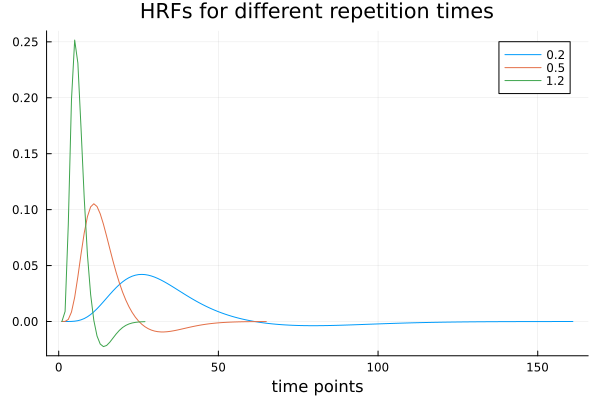

In [11]:
TRs = [0.2, 0.5, 1.2] #in seconds
hrfs = spm_hrf.(TRs) #computes the hemodynamic response function with TR
plot(hrfs, xlabel="time points", labels=TRs',title="HRFs for different repetition times")

### Deconvolution

Based on the deconvolution approach presented in https://www.sciencedirect.com/science/article/pii/S1053811921008648 for fmri time series

#### Without nuisance artifacts
<a id="nonuis"></a>

First consider the easier observation model without nuisance artifacts

$$ x_t = B (\text{hrf}\ast z_{t-\tau:t})$$

Due to hrf being the same function for all latent space dimensions (i.e. a scalar function, not a vector one), one can interchange the matrix multiplication with $B$ and the convolution with the hrf.
\begin{align}
    B (\text{hrf} \ast z)(t) &= B \int_{0}^\tau \text{hrf}(t') z(t-t') \, \text{d} t'\\
    (B (\text{hrf} \ast z)(t))_{i} &= \sum_{j=1}^M B_{i,j} \int_{0}^\tau \text{hrf}(t') z(t-t')_j \,\text{d} t'\\
    &=  \int_{0}^\tau \text{hrf}(t') \sum_{j=1}^M B_{i,j} z(t-t')_j \,\text{d} t'\\
    &=  \int_{0}^\tau \text{hrf}(t') \sum_{j=1}^M (B\cdot z(t-t'))_i \,\text{d} t'\\
     B (\text{hrf} \ast z)(t) &= (\text{hrf}\ast (B z))(t)
\end{align}
(Same argumentation for discrete convolution. Convolutions as well as matrix multiplication are linear)

One can divide the observation into two
\begin{align}
        x_t &= \text{hrf}\ast \overset{\sim}{x} _{t:t-\tau} \\
        \overset{\sim}{x}_t &= B z_{t}
\end{align}

To simplify the notation forget about problems with boundaries, noise, discrete $\Leftrightarrow$ continuous, Wiener deconvolution... and just write
\begin{align}
         \text{Conv}(\overset{\sim}{x})(t)&= x(t) = (\text{hrf}\ast \overset{\sim}{x})(t) \\
        \text{Conv}^{-1}({x})(t) &= \overset{\sim}{x}(t)
\end{align}



#### With nuisance artifacts $r_t$
<a id="nuis"></a>


One can include the nuisance artifacts $\{r_t\}$ by rewritting 
\begin{align}
    J r_t &= \text{hrf} \ast (J \overset{\sim}{r} _t)\\
    \overset{\sim}{r}(t)&=\text{Conv}^{-1}({r})(t)
\end{align}
By using the linearity of the convolution one can rewrite the original observation model
\begin{align}
    x_t &= B (\text{hrf}\ast z_{t:t-\tau}) + J r_t\\
    x_t &= (\text{hrf}\ast B z_{t:t-\tau}) + (\text{hrf}\ast (J \overset{\sim}{r} _{t:t-\tau}))\\
    x_t &= (\text{hrf}\ast \underbrace{(B z_{t:t-\tau}+ J \overset{\sim}{r} _{t:t-\tau})}_{ \overset{\sim}{x} _{t:t-\tau}})\\
    x_t &= \text{hrf}\ast  \overset{\sim}{x} _{t:t-\tau}\\
    \overset{\sim}{x}_t &= B z_{t} + J     \overset{\sim}{r}_t\\ 
     z_{t}    &= B^+ (\overset{\sim}{x}_t - J     \overset{\sim}{r}_t)
\end{align}



#### Wiener Deconvolution
<a id="wienerdeconv"></a>


Given a system $y(t) = (h \ast x)(t) + n(t)$

where

$x(t)$ the original signal we wish to recover, 
$h(t)$ the known impulse response, 
$n(t)$ additive white noise term (independent of $x(t)$) and $y(t)$ observed signal.
   
The goal is to find a function $g(t)$ so that we can estimate $x(t)$

$$\hat{x}(t) = (g \ast y)(t)$$
   
where $\hat{x}(t)$ is an estimate of $x(t)$ that minimizes the mean square error
   
The Wiener deconvolution filter provides such a $g(t)$. In the frequency domain the filter is written as

$G(k) = \frac{H*(k)S(k)}{\|H(k)\|^2 S(k) + N(k)}$

here:

$G(k)$ and $H(k)$ are the Fourier transforms of $g(t)$ and $h(t)$

$S(k) = \mathbb{E} [X(k)]^2$ is the mean power spectral density of the original signal $x(t)$

$N(k) = \mathbb{E} [V(k)]^2$ is the mean power spectral density of the noise $n(t)$

$X(k)$, $Y(k)$ and $V(k)$ are the Fourier transforms of $x(t)$, $y(t)$ and $n(t)$ respectively.

he superscript $^*$ denotes complex conjugation

sing the convolution theorem we can then obtain $\hat{X}(k) = G(k)Y(k)$ and perform an inverse Fourier transform on $\hat{X}(k)$ to obtain $\hat{x}(t)$

The function *wiener* from the [Deconvolution package](https://juliapackages.com/p/deconvolution) is used in the implementation.

#### Noise Estimation and Denoising
<a id="noisest"></a>

The Wiener Deconvolution needs an estimate of the power spectra of the noise and the original signal. The noise was assumed to be Gaussian white noise with mean $\mu=0$. As proposed by Donoho 1995, the standard deviation was estimated by $\hat{\sigma} = MAD/0.6745$ where $MAD$ is the median absolute value of the normalized finescale wavelet coefficients. (https://www.fceia.unr.edu.ar/~jcgomez/wavelets/Donoho_1995.pdf).

To estimate the original signal the noisy signal was denoised using the so called VisuShrink method, a wavelet based denoising technique. The function *noisest* from the [Wavelets package](https://github.com/JuliaDSP/Wavelets.jl) is used.

## Visualisations with artifical data

### Experimental setup
We will use the example lorenz as our time series, convolute and deconvolute it and compare the result of these two operations to the original data. We can not use actual fMRI data as we only have the convoluted version. So we stick to artifical data.


#### Create artifical convolutional data
Load lorenz data, convolute them with the hemodynamic response function and add white noise

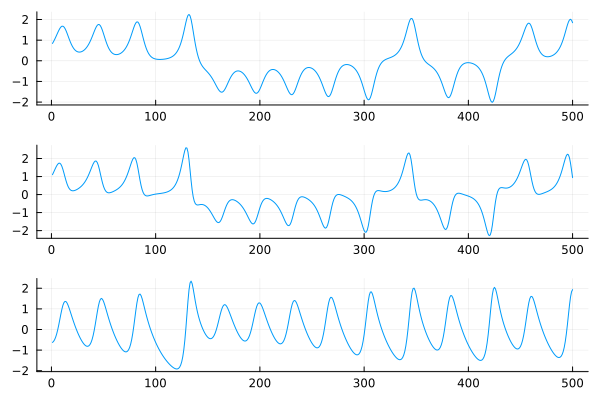

In [3]:
#load lorenz time series from file
path = "example_data/lorenz.npy"
data = npzread(path)
X_original = data[1:2:1000,:] #use only a fraction of large dataset
plot(X_original, layout = (3,1), labels=false)

Convolute the X_original with the hemodynamic response function to mimick fMRI-BOLD-data and add white noise

In [4]:
TR = 0.3 #in seconds
noise_big = 0.1
noise_small = 0.01
hrf = spm_hrf(TR) #computes the hemodynamic response function with TR
padding = length(hrf) - 1
X_conv = hrf_conv(X_original, hrf) #convolutes time series with hrf
dist_big = Normal(0., noise_big) #a normal distribution with standard deviation "noise"
dist_small = Normal(0., noise_small) #a normal distribution with standard deviation "noise"
rng = MersenneTwister(0) #random seed

X_conv_noise_big = X_conv + rand(rng, dist_big, size(X_conv));
X_conv_noise_small = X_conv + rand(rng, dist_small, size(X_conv));

#### Plots of the produced data

3-dimensional plot of the state space. One can see the strange attractor and its convoluted pendant

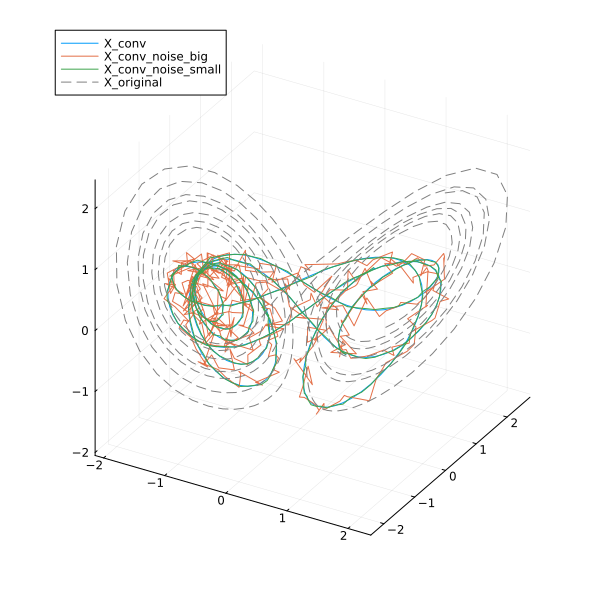

In [33]:
plot(X_conv[:,1], X_conv[:,2], X_conv[:,3], label = "X_conv", size=(600,600))
plot!(X_conv_noise_big[:,1], X_conv_noise_big[:,2], X_conv_noise_big[:,3], label = "X_conv_noise_big")
plot!(X_conv_noise_small[:,1], X_conv_noise_small[:,2], X_conv_noise_small[:,3], label = "X_conv_noise_small")
plot!(X_original[:,1], X_original[:,2], X_original[:,3], label = "X_original", color=:gray, linestyle=:dash)

3 dimensions plotted with respect to the time steps.

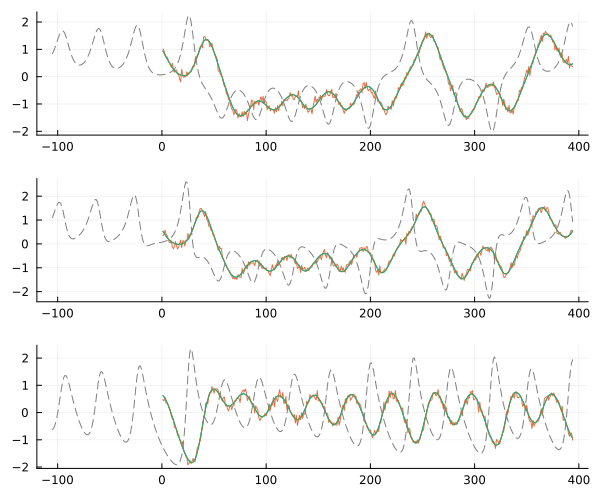

In [34]:
padding = length(hrf)-1
plot(X_conv[:,:], labels=false, layout=(3,1), size=(600,500))
plot!(X_conv_noise_big[:,:], labels=false, layout=(3,1))
plot!(X_conv_noise_small[:,:], labels=false, layout=(3,1))
plot!(range(1-padding,size(X_original,1)-padding), X_original[:,:], labels=false, color=:gray, linestyle=:dash, layout=(3,1))

Notice that the convoluted time series are shorter than the original signal. To be able to compute earlier convoluted states one would need information not available due to the finiteness of the original signal. In a fMRI situation our first measurements are influenced by latent states not even in the measurement time but before that.

### Deconvolution

#### Hyperparameter **min_conv_noise**
<a id="minconvnoise"></a>

Deconvolute X_conv (without and with minimal noise level) and compare it to our ground truth.

In [15]:
#deconvolution of the dataset without noise and no minimal noise level
X_deconv, _ = Wiener_Deconvolution(X_conv, hrf, 0f0); 
#deconvolution of the dataset without noise and with minimal noise level
min_conv_noise = 0.001f0
X_deconv_min, low_noise_list = Wiener_Deconvolution(X_conv, hrf, min_conv_noise);

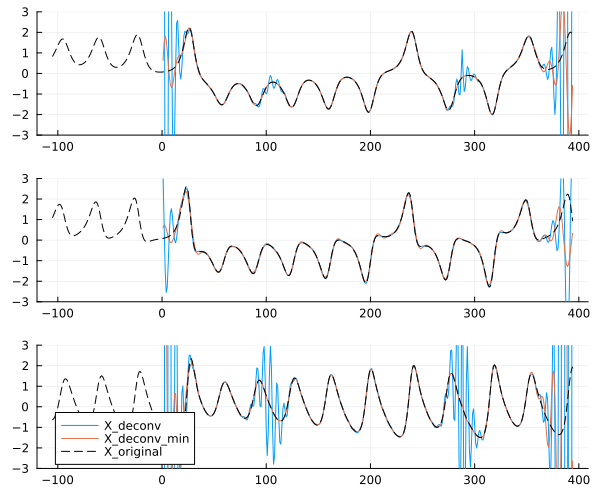

In [16]:
#plot_title="Deconvoluted time series in comparison to X_original"
absplot = plot(layout=(3,1), size=(600,500))
plot!(absplot,X_deconv, layout=(3,1), label = "X_deconv")
plot!(absplot,X_deconv_min, layout=(3,1), label = "X_deconv_min")
plot!(absplot,range(1-padding,size(X_original,1)-padding), X_original, label = "X_original", color=:black, linestyle=:dash, layout=(3,1), ylim=(-3,3))
#vline!(absplot,[[0.25*padding],[0.25*padding],[0.25*padding]], label="cut_l = 0.25 length(hrf)", color=:gray ,linestyle=:dash, layout=(3,1))
#vline!(absplot,[[size(X_deconv,1)-0.25*padding],[size(X_deconv,1)-0.25*padding],[size(X_deconv,1)-0.25*padding]], label="cut_r = 0.25 length(hrf)", color=:red ,linestyle=:dash, layout=(3,1))
plot!(absplot[1], legend = false)
plot!(absplot[2], legend = false)
plot!(absplot[3], legend = :bottomleft)

Although the blue curve was given the convoluted time series without noise, it exhibits high frequency artifacts at several time intervals. This is due to numerical precisions errors and can be prohibited by choosing a minmal noise level (hyperparameter **min_conv_noise**), which the Wiener deconvolution uses when it only detects a smaller noise. In our example, the high frequency artifacts of the orange line are only at the boundaries and could be eliminated by the [two cut hyperparameter **cut_l** (cut left) and **cut_r** (cut right)](#cutlcutr), see next subchapter.

In most experimental cases, such small noise level should not occur. But if the preprocessing eridicated all noise detectable by the method used in the code it can be useful to set such a minimal noise level. If the noise is big enough it is ignored anyways. For the first deconvolution (i.e. not if loaded from file) of the trainset data, the code will give a warning if the min_conv_noise parameter was used:

In [17]:
isempty(low_noise_list) ? nothing : println("The computed noise_levels of dimensions $(low_noise_list) are lower than the chosen minimal noise level $(min_conv_noise).")

The computed noise_levels of dimensions [1, 2, 3] are lower than the chosen minimal noise level 0.001.


##### Plot of the deviations

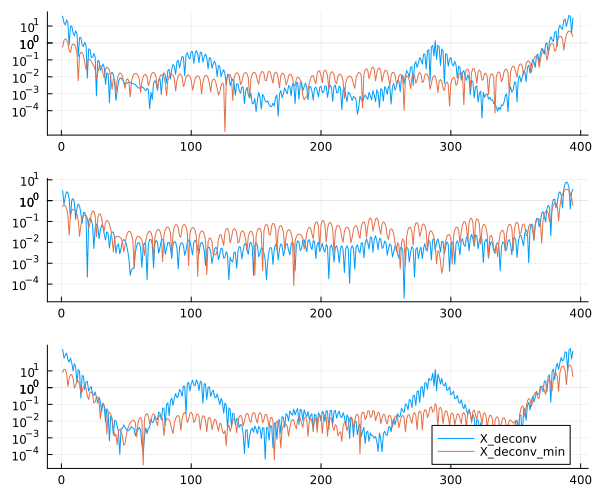

In [19]:
#plot_title="Deviation from X_original"
magnitudes = [10e-5,10e-4,10e-3, 10e-2, 10e-1,1, 10]
diffplot = plot(layout=(3,1), size=(600,500))
plot!(diffplot,abs.(X_original[1+padding:end,:]-X_deconv), layout=(3,1), label = "X_deconv", yaxis=:log, yticks=magnitudes)
plot!(diffplot,abs.(X_original[1+padding:end,:]-X_deconv_min), layout=(3,1), label = "X_deconv_min")
plot!(diffplot[1], legend = false)
plot!(diffplot[2], legend = false)
plot!(diffplot[3], legend = :bottomright)

#### Hyperparameters **cut_l** and **cut_r**
<a id="cutlcutr"></a>

Short explanation on how these hyperparameters are interpreted

*help = "Set to 0 to ignore. How much in terms of length of the hrf is cropped from the deconvoluded data at the beginning/end. 
Choose Float between 0 and 1 to interpret it as ratio. If bigger than 1 it will be interpreted as integer"*

Deconvolute the convoluted timeseries with big and small noise and compare it to our ground truth

In [35]:
#deconvolution of the dataset with big noise
X_deconv_noise_big, _ = Wiener_Deconvolution(X_conv_noise_big, hrf, 0f0);
#deconvolution of the dataset with small noise
X_deconv_noise_small, _ = Wiener_Deconvolution(X_conv_noise_small, hrf, 0f0);

##### Plot: Deconvoluted time series and ground truth

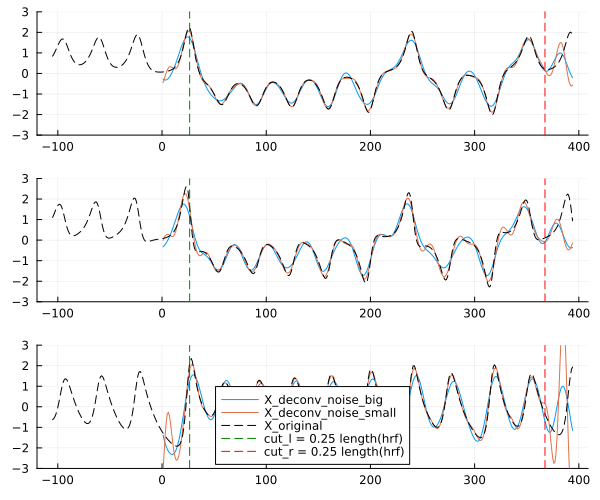

In [38]:
cut_l = Int(floor(0.25*padding))
cut_r = Int(floor(0.25*padding))

absplot = plot(layout=(3,1), size=(600,500))
plot!(absplot,X_deconv_noise_big, layout=(3,1), label = "X_deconv_noise_big")
plot!(absplot,X_deconv_noise_small, layout=(3,1), label = "X_deconv_noise_small")
plot!(absplot,range(1-padding,size(X_original,1)-padding), X_original, label = "X_original", color=:black, linestyle=:dash, layout=(3,1), ylim=(-3,3))
vline!(absplot,[[0.25*padding],[0.25*padding],[0.25*padding]], label="cut_l = 0.25 length(hrf)", color=:green ,linestyle=:dash, layout=(3,1))
vline!(absplot,[[size(X_deconv_noise_big,1)-0.25*padding],[size(X_deconv_noise_big,1)-0.25*padding],[size(X_deconv_noise_big,1)-0.25*padding]], label="cut_r = 0.25 length(hrf)", color=:red ,linestyle=:dash, layout=(3,1))
plot!(absplot[1], legend = false)
plot!(absplot[2], legend = false)
plot!(absplot[3], legend = :bottom)

One can see that the estimated deconvoluted states differ from the ground truth at the boundaries. This effect is more pronounced for the states at the end of the time series as one would expect since these would also influence future states not measured and therefore not available to draw inferences from.

To be able to cut these off, the hyperparameter **cut_r** (cut right) is introduced in the code. These states are not used to get initial conditions or as forcing signals but their corresponding measurements $x_t$ are used in the MSE. Meaning non of these informations are lost by the cutting off if the chosen sequence length permits a evolution from the last possible initial state $z_{T-cutr}$ to the end state $z_T$, i.e. if the sequence length is 
longer than cut_r. Choosing a higher **cut_r** not necessarily results in information loss but the loss of forcing signals. Although the are more an more unreliable that [can pose a problem](https://papers.nips.cc/paper_files/paper/2022/file/495e55f361708bedbab5d81f92048dcd-Paper-Conference.pdf).

Whereas for the hyperparameter **cut_l** (cut left) neither derived deconvoluted nor measurements are included in the training and as a consequence these information are lost. So one has to weigh the gain of information by choosing a small **cut_l** against the more unreliable initial states included by that choice.

##### Plot: 3D State space

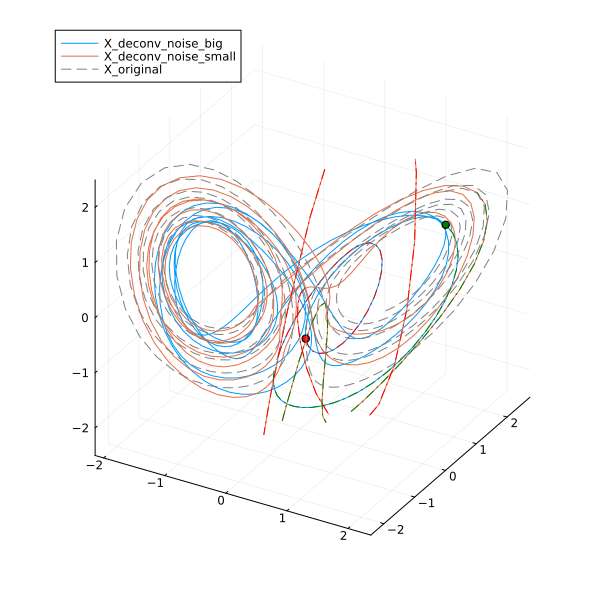

In [39]:
#[[-2,2],[-2,2],[-2,2]]
plot(X_deconv_noise_big[:,1], X_deconv_noise_big[:,2], X_deconv_noise_big[:,3], label = "X_deconv_noise_big", zlims=[-2.5,2.5], size=(600,600))
plot!([X_deconv_noise_small[:,1]], [X_deconv_noise_small[:,2]], [X_deconv_noise_small[:,3]], label = "X_deconv_noise_small")
plot!(X_deconv_noise_big[1:cut_l,1], X_deconv_noise_big[1:cut_l,2], X_deconv_noise_big[1:cut_l,3], color=:green, linestyle=:dashdot, label=false)
plot!(X_deconv_noise_small[1:cut_l,1], X_deconv_noise_small[1:cut_l,2], X_deconv_noise_small[1:cut_l,3], color=:green, linestyle=:dashdot, label=false)
plot!(X_deconv_noise_big[end-cut_r:end,1], X_deconv_noise_big[end-cut_r:end,2], X_deconv_noise_big[end-cut_r:end,3], color=:red, linestyle=:dashdot, label=false)
plot!(X_deconv_noise_small[end-cut_r:end,1], X_deconv_noise_small[end-cut_r:end,2], X_deconv_noise_small[end-cut_r:end,3], color=:red, linestyle=:dashdot, label=false)
#plot!([X_deconv_noise_small[:,1]], [X_deconv_noise_small[:,2]], [X_deconv_noise_small[:,3]], label = "X_deconv_noise_small")
scatter!([X_deconv_noise_big[cut_l,1]], [X_deconv_noise_big[cut_l,2]], [X_deconv_noise_big[cut_l,3]], color=:green, label=false)
scatter!([X_deconv_noise_big[end-cut_l,1]], [X_deconv_noise_big[end-cut_l,2]], [X_deconv_noise_big[end-cut_l,3]], color=:red, label=false)
plot!(X_original[:,1], X_original[:,2], X_original[:,3], label = "X_original", color=:gray, linestyle=:dash)

##### Plot: Absolute deviations with regards to the ground truth

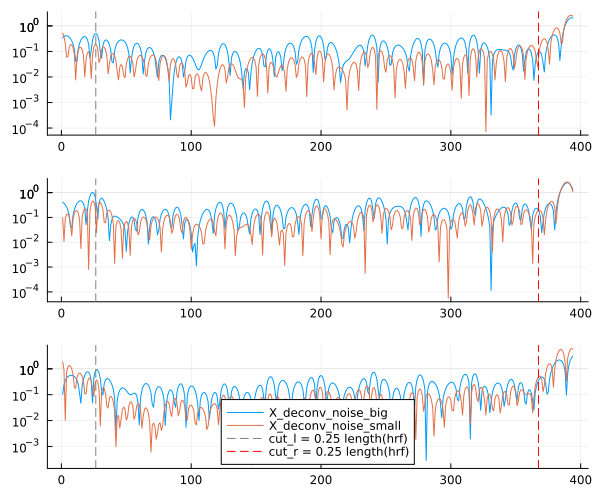

In [42]:
magnitudes = [10e-5,10e-4,10e-3, 10e-2, 10e-1,1, 10]
diffplot = plot(layout=(3,1), size=(600,500))
plot!(diffplot,abs.(X_original[1+padding:end,:]-X_deconv_noise_big), layout=(3,1), label = "X_deconv_noise_big", yaxis=:log, yticks=magnitudes)
plot!(diffplot,abs.(X_original[1+padding:end,:]-X_deconv_noise_small), layout=(3,1), label = "X_deconv_noise_small")
vline!(diffplot,[[0.25*padding],[0.25*padding],[0.25*padding]], label="cut_l = 0.25 length(hrf)", color=:gray ,linestyle=:dash, layout=(3,1))
vline!(diffplot,[[size(X_deconv_noise_big,1)-0.25*padding],[size(X_deconv_noise_big,1)-0.25*padding],[size(X_deconv_noise_big,1)-0.25*padding]], label="cut_r = 0.25 length(hrf)", color=:red ,linestyle=:dash, layout=(3,1))
plot!(diffplot[1], legend = false)
plot!(diffplot[2], legend = false)
plot!(diffplot[3], legend = :bottom)